
#Image Generation using Variational Autoencoders (VAE)

Variational Autoencoders (VAE) are powerful generative models that learn to:
1. Compress (encode) data into a lower-dimensional latent space
2. Decompress (decode) points from this latent space back into data
3. Ensure the latent space is continuous and well-structured

What makes VAEs special for generation:
- They learn a probabilistic mapping to/from latent space
- The latent space is continuous, allowing interpolation
- They can generate new, realistic data by sampling from latent space

Use Case:
This notebook demonstrates how to generate new handwritten digits using MNIST data.
The VAE will learn to compress 28x28 digit images into a 2D latent space,
then generate new digits by sampling from this space.
"""

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ---------------------------
# 1. Load and Preprocess MNIST
# ---------------------------
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# ---------------------------
# 2. Define Hyperparameters and Input Shape
# ---------------------------
latent_dim = 2  # Dimensionality of the latent space
input_shape = (28, 28, 1)


In [4]:
# ---------------------------
# 3. Build the Encoder
# ---------------------------
inputs = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ---------------------------
# 4. Build the Decoder
# ---------------------------
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ---------------------------
# 5. Define the VAE Model with Custom Training
# ---------------------------
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Forward pass: encode then decode
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

vae = VAE(encoder, decoder)
# Pass the loss function to the compile method
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=lambda x, y: x) # or use a dummy loss function


In [10]:
# ---------------------------
# 6. Train the VAE
# ---------------------------
epochs = 10  # For demonstration, using 10 epochs; adjust as needed.
# The problem is validation_data=(x_test, None), you need to provide dummy target to x_test
# Replace None with np.zeros(x_test.shape[0]) as a dummy target
vae.fit(x_train, epochs=epochs, batch_size=128, validation_data=(x_test, np.zeros(x_test.shape[0])))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 181ms/step - kl_loss: 4.7461 - loss: 178.5519 - reconstruction_loss: 173.8058 - val_loss: 0.0000e+00
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 178ms/step - kl_loss: 6.0620 - loss: 167.5073 - reconstruction_loss: 161.4453 - val_loss: 0.0000e+00
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 180ms/step - kl_loss: 6.2370 - loss: 164.3594 - reconstruction_loss: 158.1224 - val_loss: 0.0000e+00
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 181ms/step - kl_loss: 6.2921 - loss: 162.2591 - reconstruction_loss: 155.9670 - val_loss: 0.0000e+00
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 178ms/step - kl_loss: 6.3214 - loss: 160.7180 - reconstruction_loss: 154.3966 - val_loss: 0.0000e+00
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 180ms/step - kl_loss: 6.3352 - loss: 159.6017 - reconstruction_loss: 153.2665 - val_loss: 0.0000e+00
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 184ms/step - kl_loss: 6.3465 - loss: 158.7677 - reconstruction_loss: 152.4212 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


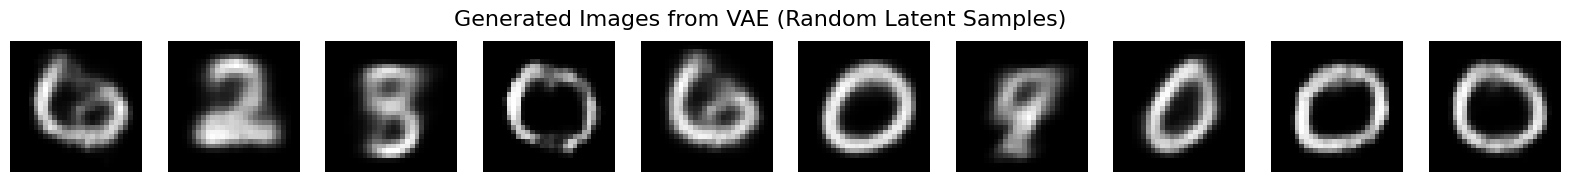

In [11]:
# ---------------------------
# 7. Generate New Images by Sampling the Latent Space
# ---------------------------
num_samples = 10  # Number of images to generate
# Sample random points in the latent space (from a standard normal distribution)
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
# Use the decoder to generate images from these latent vectors
generated_images = decoder.predict(random_latent_vectors)

# Plot the generated images
plt.figure(figsize=(20, 2))
for i in range(num_samples):
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Images from VAE (Random Latent Samples)", fontsize=16)
plt.show()
